### House prices advanced regression techniques
#### https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing._encoders import _BaseEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import mutual_info_regression, SelectKBest, chi2
from sklearn.metrics import r2_score
import seaborn as sbn
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import csv
from sklearn import tree
from tensorflow import keras
from keras import Sequential, models

In [2]:
## Reference is https://frankworkshophome.wordpress.com/2019/11/02/a-better-encoder-for-sklearn-2/
class Custom_OrdinalEncoder(_BaseEncoder):
    def __init__(self,cat_index='all'):
        self.dicts={}
        # cate_index is the categorical feature index list
        self.cat_index=cat_index
     
    def fit(self,df,*y):
        if self.cat_index=='all':
            self.cat_index=list(range(df.shape[1]))
        for feat in self.cat_index:
            dic=np.unique(df.iloc[:,feat])
            dic=dict([(i,index) for index, i in enumerate(dic)])
            self.dicts[feat]=dic
             
    def fit_transform(self,df,*y):
        if self.cat_index=='all':
            self.cat_index=list(range(df.shape[1]))
        df_output=df.copy()
        for feat in self.cat_index:
            dic=np.unique(df.iloc[:,feat])
            dic=dict([(i,index) for index, i in enumerate(dic)])
            self.dicts[feat]=dic
            df_output.iloc[:,feat]=df.iloc[:,feat].apply(lambda x: dic[x])
        return df_output
         
    def transform(self,df):
        df_output=df.copy()
        for feat in self.cat_index:
            dic=self.dicts[feat]
            df_output.iloc[:,feat]=df.iloc[:,feat].apply(self.unknown_value,args=(dic,))
        return df_output
     
    def unknown_value(self,value,dic): # It will set up a new interger for unknown values!
        try:
            return dic[value]
        except:
            return len(dic)

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
df = pd.read_csv('./train.csv')

In [5]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,Gas

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
updated_df = df.copy()

### Clean Data

In [8]:
df[df['LotFrontage'].isna()].sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1354,1355,60,RL,NaN,10316,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,735,Unf,0,257,992,GasA,Ex,Y,SBrkr,992,873,0,1865,1,0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,2000.0,RFn,3,839,TA,TA,Y,0,184,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,235000
470,471,120,RL,NaN,6820,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1985,1985,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,368,BLQ,1120,0,1488,GasA,TA,Y,SBrkr,1502,0,0,1502,1,0,1,1,1,1,Gd,4,Typ,0,NaN,Attchd,1985.0,RFn,2,528,TA,TA,Y,0,54,0,0,140,0,NaN,NaN,NaN,0,6,2010,WD,Normal,212000
714,715,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533,Unf,0,192,725,GasA,Ex,Y,SBrkr,725,754,0,1479,0,0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2,475,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal,130500
12,13,20,RL,NaN,12968,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1962,1962,Hip,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,737,Unf,0,175,912,GasA,TA,Y,SBrkr,912,0,0,912,1,0,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1962.0,Unf,1,352,TA,TA,Y,140,0,0,0,176,0,NaN,NaN,NaN,0,9,2008,WD,Normal,144000
152,153,60,RL,NaN,14803,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NWAmes,Norm,Norm,1Fam,2Story,6,5,1971,1971,Gable,CompShg,HdBoard,HdBoard,BrkFace,252.0,TA,TA,CBlock,TA,TA,No,Rec,416,Unf,0,409,825,GasA,Gd,Y,SBrkr,1097,896,0,1993,0,0,2,1,4,1,TA,8,Typ,1,Gd,Attchd,1971.0,RFn,2,495,TA,TA,Y,0,66,0,0,0,0,NaN,GdWo,NaN,0,6,2006,WD,Normal,190000


In [9]:
df[~df['LotFrontage'].isna()].sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1408,1409,70,RM,60.0,7740,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,4,7,1910,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,Fa,TA,No,Unf,0,Unf,0,622,622,GasA,Gd,Y,SBrkr,741,622,0,1363,0,0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1966.0,Unf,2,528,TA,TA,Y,0,0,0,0,168,0,NaN,NaN,NaN,0,6,2010,WD,Normal,125500
339,340,20,RL,66.0,12400,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,6,7,1958,1998,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,176.0,TA,TA,CBlock,TA,Fa,No,Rec,585,Unf,0,630,1215,GasA,TA,Y,FuseA,1215,0,0,1215,0,0,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1958.0,Unf,1,297,TA,TA,Y,0,0,0,0,234,0,NaN,NaN,NaN,0,6,2009,WD,Normal,155000
1012,1013,70,RL,55.0,10592,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,6,7,1923,1996,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Gd,PConc,TA,Fa,No,Unf,0,Unf,0,602,602,GasA,TA,Y,SBrkr,900,602,0,1502,0,0,1,1,3,1,Gd,7,Typ,2,TA,Detchd,1923.0,Unf,1,180,TA,TA,Y,96,0,112,0,53,0,NaN,NaN,NaN,0,8,2007,WD,Normal,165000
605,606,60,RL,85.0,13600,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,2Story,7,6,1965,1990,Gable,CompShg,HdBoard,HdBoard,BrkFace,176.0,TA,TA,CBlock,TA,TA,No,BLQ,454,Unf,0,314,768,GasA,TA,Y,SBrkr,1186,800,0,1986,0,0,2,1,3,1,TA,7,Typ,3,Fa,Attchd,1965.0,Unf,2,486,TA,TA,Y,0,42,0,0,189,0,NaN,NaN,NaN,0,10,2009,WD,Normal,205000
1050,1051,20,RL,73.0,8993,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1302,1302,GasA,Ex,Y,SBrkr,1302,0,0,1302,0,0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,2007.0,Fin,2,436,TA,TA,Y,0,22,0,0,0,0,NaN,NaN,NaN,0,8,2007,New,Partial,176485


In [10]:
df.loc[range(642,652)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
642,643,80,RL,75.0,13860,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,SLvl,8,7,1972,1995,Gable,CompShg,Plywood,Wd Sdng,None,0.0,Gd,TA,CBlock,Gd,TA,Gd,GLQ,1410,Unf,0,542,1952,GasA,Gd,Y,SBrkr,2000,704,0,2704,1,0,2,1,4,1,Ex,9,Typ,3,TA,Attchd,1972.0,Fin,2,538,TA,TA,Y,269,111,0,0,0,0,NaN,MnPrv,NaN,0,7,2009,WD,Normal,345000
643,644,60,RL,80.0,10793,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,RRAn,Norm,1Fam,2Story,5,5,1969,1969,Mansard,CompShg,WdShing,HdBoard,BrkFace,263.0,TA,TA,CBlock,TA,TA,No,Rec,493,BLQ,287,0,780,GasA,Ex,Y,SBrkr,780,840,0,1620,0,0,2,1,4,1,TA,7,Min1,0,NaN,Attchd,1969.0,Fin,2,462,TA,TA,Y,208,0,0,0,0,0,NaN,GdWo,NaN,0,4,2007,WD,Normal,152000
644,645,20,FV,85.0,9187,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,9,5,2009,2009,Gable,CompShg,CemntBd,CmentBd,Stone,162.0,Ex,TA,PConc,Ex,TA,Mn,GLQ,1121,Unf,0,645,1766,GasA,Ex,Y,SBrkr,1766,0,0,1766,1,0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2009.0,Fin,3,478,TA,TA,Y,195,130,0,0,0,0,NaN,NaN,NaN,0,10,2009,New,Partial,370878
645,646,20,RL,NaN,10530,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1971,1971,Hip,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,282,LwQ,35,664,981,GasA,TA,Y,SBrkr,981,0,0,981,1,0,1,1,3,1,TA,5,Typ,0,NaN,Detchd,1979.0,Unf,2,576,TA,TA,Y,0,312,40,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal,143250
646,647,20,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1950,1950,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Gd,Y,SBrkr,1048,0,0,1048,0,0,1,0,3,1,TA,7,Min1,0,NaN,Detchd,1950.0,Unf,2,420,TA,TA,Y,0,27,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,98300
647,648,20,RL,85.0,10452,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,6,5,1953,1953,Hip,CompShg,Wd Sdng,Wd Sdng,Stone,216.0,TA,TA,CBlock,TA,TA,Mn,Rec,500,Unf,0,594,1094,GasA,Ex,Y,SBrkr,1094,0,0,1094,0,0,1,0,3,1,TA,5,Typ,2,Gd,Attchd,1953.0,RFn,2,495,TA,TA,Y,0,0,0,0,287,0,NaN,NaN,NaN,0,6,2008,WD,Normal,155000
648,649,60,RL,70.0,7700,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,PosN,Norm,1Fam,2Story,6,5,1966,1966,Gable,CompShg,MetalSd,MetalSd,BrkFace,351.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,756,756,GasA,TA,Y,SBrkr,1051,788,0,1839,0,0,1,1,4,1,TA,7,Typ,1,TA,Attchd,1966.0,Unf,2,442,TA,TA,Y,0,124,216,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,155000
649,650,180,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,SFoyer,4,6,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,131,GLQ,499,0,630,GasA,Gd,Y,SBrkr,630,0,0,630,1,0,1,0,1,1,TA,3,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,12,2007,WD,Normal,84500
650,651,60,FV,65.0,8125,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,813,813,GasA,Ex,Y,SBrkr,822,843,0,1665,0,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,2007.0,RFn,2,562,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,205950
651,652,70,RL,60.0,9084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Artery,Norm,1Fam,2Story,4,5,1940,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,Unf,0,Unf,0,755,755,GasA,TA,Y,

#### Drop LotFrontage because of over 200 missing records. Unable to ffil

In [11]:
updated_df.drop(columns='LotFrontage', inplace=True)

In [12]:
updated_df[updated_df['MasVnrType'].isna()]

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
234,235,60,RL,7851,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,625,Unf,0,235,860,GasA,Ex,Y,SBrkr,860,1100,0,1960,1,0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2,440,TA,TA,Y,288,48,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,216500
529,530,20,RL,32668,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,NaN,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219,Unf,0,816,2035,GasA,TA,Y,SBrkr,2515,0,0,2515,1,0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2,484,TA,TA,Y,0,0,200,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Alloca,200624
650,651,60,FV,8125,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,813,813,GasA,Ex,Y,SBrkr,822,843,0,1665,0,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,2007.0,RFn,2,562,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,205950
936,937,20,RL,10083,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,833,Unf,0,343,1176,GasA,Ex,Y,SBrkr,1200,0,0,1200,1,0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,2003.0,RFn,2,555,TA,TA,Y,0,41,0,0,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal,184900
973,974,20,FV,11639,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1428,1428,GasA,Ex,Y,SBrkr,1428,0,0,1428,0,0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,2007.0,Fin,2,480,TA,TA,Y,0,120,0,0,0,0,NaN,NaN,NaN,0,12,2008,New,Partial,182000
977,978,120,FV,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,1106,Unf,0,135,1241,GasA,Ex,Y,SBrkr,1241,0,0,1241,1,0,1,1,1,1,Gd,4,Typ,0,NaN,Attchd,2007.0,Fin,2,569,TA,TA,Y,0,116,0,0,0,0,NaN,NaN,NaN,0,11,2007,New,Partial,199900
1243,1244,20,RL,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386,Unf,0,690,2076,GasA,Ex,Y,SBrkr,2076,0,0,2076,1,0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3,850,TA,TA,Y,216,229,0,0,0,0,NaN,NaN,NaN,0,9,2006,New,Partial,465000
1278,1279,60,RL,9473,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,804,Unf,0,324,1128,GasA,Ex,Y,SBrkr,1128,903,0,2031,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002.0,RFn,2,577,TA,TA,Y,0,211,0,0,0,0,NaN,NaN,NaN,0,3,2008,WD,Normal,237000


#### Replace null mansonry area and type with 0 and None for the NAs

In [13]:
updated_df['MasVnrType'].replace(to_replace=np.nan, value='None', inplace=True)

In [14]:
updated_df['MasVnrArea'].replace(to_replace=np.nan, value=0.0, inplace=True)

In [15]:
updated_df[(~updated_df['BsmtCond'].isna()) & (updated_df['BsmtExposure'].isna())]

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
948,949,60,RL,14006,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,144.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0,Unf,0,936,936,GasA,Ex,Y,SBrkr,936,840,0,1776,0,0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,2002.0,RFn,2,474,TA,TA,Y,144,96,0,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Normal,192500


#### Replace BsmtCond for that row with NA since BsmtExposure says there is no basement

In [16]:
updated_df.at[948, 'BsmtCond'] = np.nan

In [17]:
updated_df[updated_df['Electrical'].isna()]

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,9735,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500


In [18]:
updated_df.at[1379, 'Electrical']= 'SBrkr'

In [19]:
updated_df[(updated_df['GarageType'].isna()) & (~updated_df['GarageArea'].isna())]

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
39,40,90,RL,6040,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,5,1955,1955,Gable,CompShg,AsbShng,Plywood,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,N,FuseP,1152,0,0,1152,0,0,2,0,2,2,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,AdjLand,82000
48,49,190,RM,4456,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,5,1920,2008,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,736,736,GasA,Gd,Y,SBrkr,736,716,0,1452,0,0,2,0,2,3,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,102,0,0,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
78,79,90,RL,10778,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1968,1968,Hip,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1768,1768,GasA,TA,N,SBrkr,1768,0,0,1768,0,0,2,0,4,2,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,136500
88,89,50,C (all),8470,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,GasA,TA,N,SBrkr,1013,0,513,1526,0,0,1,0,2,1,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,156,0,0,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml,85000
89,90,20,RL,8070,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,4,5,1994,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,588,Unf,0,402,990,GasA,Ex,Y,SBrkr,990,0,0,990,1,0,1,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,123600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,1350,70,RM,5250,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,8,5,1872,1987,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,BrkTil,TA,Fa,No,LwQ,259,Unf,0,425,684,OthW,Fa,N,SBrkr,938,1215,205,2358,0,0,2,0,4,1,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,54,20,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,122000
1407,1408,20,RL,8780,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,5,1985,1985,Gable,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,625,Unf,0,208,833,GasA,Ex,Y,SBrkr,833,0,0,833,1,0,1,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,3,2009,WD,Normal,112000
1449,1450,180,RM,1533,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,SFoyer,5,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,Gd,TA,Av,GLQ,553,Unf,0,77,630,GasA,Ex,Y,SBrkr,630,0,0,630,1,0,1,0,1,1,Ex,3,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD,Abnorml,92000
1450,1451,90,RL,9000,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,Duplex,2Story,5,5,1974,1974,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,896,896,GasA,TA,Y,SBrkr,896,896,0,1792,0,0,2,2,4,2,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,32,45,0,0,0,0,NaN,NaN,NaN,0,9,2009,WD,No

In [20]:
updated_df.drop(columns='Id', inplace=True, axis=1)

In [21]:
updated_df.drop(columns='GarageYrBlt', inplace=True, axis=1)

In [22]:
updated_df.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Get columns based on type, normalize data and set pipeline

In [23]:
updated_df = updated_df.astype({'MSSubClass':str})

In [24]:
updated_df = updated_df.astype({'MoSold':str})

In [25]:
numerical_columns = updated_df.select_dtypes(['float64', 'int64']).columns

In [26]:
numerical_columns = numerical_columns.drop('SalePrice')

In [27]:
numerical_columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'YrSold'],
      dtype='object')

In [28]:
ordinal_columns = ['MSSubClass', 'LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond',
                   'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
                   'PoolQC', 'Fence', 'SaleCondition'
                   ]

In [29]:
one_hot_columns = ['MSZoning', 'Street', 'Alley', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
                   'BldgType', 'HouseStyle','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                   'Heating', 'CentralAir', 'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature', 'MoSold',
                   'SaleType'
                  ]

In [30]:
updated_df = updated_df.astype({i:'str' for i in ordinal_columns})
updated_df = updated_df.astype({i:'str' for i in one_hot_columns})

In [31]:
ordinal_encoder = Custom_OrdinalEncoder()

In [32]:
from sklearn.preprocessing import OneHotEncoder

In [33]:
one_hot_encoder = OneHotEncoder(categories=one_hot_columns, handle_unknown='ignore')

In [34]:
transformers = [('ordinal_category', ordinal_encoder, ordinal_columns),
                ('num', StandardScaler(), numerical_columns),
               ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'), one_hot_columns)]

In [35]:
merged_columns = ordinal_columns.copy()
merged_columns.extend(numerical_columns)
merged_columns.extend(one_hot_columns)

In [36]:
Y_train = updated_df['SalePrice']

In [37]:
X_train = updated_df[merged_columns]

In [38]:
# X_train = pd.get_dummies(X, columns=one_hot_columns, drop_first=True)

In [39]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [40]:
col_transform = ColumnTransformer(transformers=transformers, remainder='passthrough')

In [41]:
test_data = pd.read_csv('./test.csv')

In [42]:
X_test = test_data[merged_columns]

In [43]:
X_test = X_test.astype({'MoSold':str})

In [44]:
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [45]:
def run_regression_with_k_value(regression_model, k='all'):
    kBest = SelectKBest(score_func=mutual_info_regression, k=k)
    pipeline = Pipeline([('col_tr', col_transform), ('kBest', kBest),('model', regression_model)])
    result = pipeline.fit(X_train, Y_train)
    predict_train = pipeline.predict(X_train)
    print("Prediction score on training data is ", r2_score(Y_train, predict_train))
    print("RMSE on training data is ", mean_squared_error(Y_train, predict_train, squared=False))
    print("MSE on training data is ", mean_squared_error(Y_train, predict_train, squared=True))
    print("Mae on training data is ", mean_absolute_error(Y_train, predict_train))
    print("Mape on training data is ", mean_absolute_percentage_error(Y_train, predict_train))
    predict_test = pipeline.predict(X_test)
    filename = str(type(regression_model))+"prediction.csv"
    with (open(filename, 'w')) as file:
        writer = csv.writer(file)
        writer.writerow(['Id', 'SalePrice'])
        for index, val in enumerate(predict_test):
            writer.writerow([(1461+index), val])
    return result['kBest'], result['model']

In [46]:
str(type(one_hot_encoder))

"<class 'sklearn.preprocessing._encoders.OneHotEncoder'>"

#### Make predictions with 4 different models

In [47]:
regression_kbest, regression_model =  run_regression_with_k_value(LinearRegression(), 40)

Prediction score on training data is  0.8325506326343027
RMSE on training data is  32497.196167145572
MSE on training data is  1056067758.725941
Mae on training data is  19329.856424457248
Mape on training data is  0.11460303255987143


In [48]:
ridge_kbest, ridge_model =  run_regression_with_k_value(Ridge(), 40)

Prediction score on training data is  0.8338120677921608
RMSE on training data is  32374.560288461114
MSE on training data is  1048112153.8712033
Mae on training data is  19209.54449256541
Mape on training data is  0.11355370461302086


In [49]:
lasso_kbest, lasso_model =  run_regression_with_k_value(Lasso(), 40)

Prediction score on training data is  0.8316508655809941
RMSE on training data is  32584.388889577494
MSE on training data is  1061742399.3072212
Mae on training data is  19359.762894339452
Mape on training data is  0.11433968316122564


In [50]:
elastic_kbest, elastic_model =  run_regression_with_k_value(ElasticNet(), 40)

Prediction score on training data is  0.8164839019407297
RMSE on training data is  34020.54133120236
MSE on training data is  1157397232.468048
Mae on training data is  20102.204046892926
Mape on training data is  0.11469061623884083


In [51]:
grd_kbest, grd_model =  run_regression_with_k_value(GradientBoostingRegressor(criterion='squared_error',
                                                                              validation_fraction=0.2), 'all')

Prediction score on training data is  0.9656229578854766
RMSE on training data is  14724.42653572451
MSE on training data is  216808736.80594808
Mae on training data is  10849.729894748174
Mape on training data is  0.06631741570940668


In [52]:
dtree_kbest, dtree_model =  run_regression_with_k_value(tree.DecisionTreeRegressor(), 40)

Prediction score on training data is  0.9999969455613789
RMSE on training data is  138.793726912051
MSE on training data is  19263.698630136987
Mae on training data is  5.136986301369863
Mape on training data is  3.843758980745282e-05


In [53]:
rfr_kbest, rfr_model =  run_regression_with_k_value(
    RandomForestRegressor(n_estimators=100 ), 'all') # Error of 0.14+ on submission

Prediction score on training data is  0.9818473997827903
RMSE on training data is  10699.748214061257
MSE on training data is  114484611.84430705
Mae on training data is  6473.954075342465
Mape on training data is  0.03770312874267231


#### So far, GradientBoostingRegressor has better performance on the test data with error of 0.13+ on Kaggle

### Using GridSearchCV with kfold to get the best model and best features with cross validation

In [54]:
from sklearn.model_selection import GridSearchCV

In [55]:
def run_regression_with_kbest_value_and_cv():
    kBest = SelectKBest(score_func=mutual_info_regression, k=3)
    pipeline = Pipeline([('col_tr', col_transform), ('kBest', kBest),('model', LinearRegression())])
    params = [
        {'kBest__k' : [3, 5, 10, 15, 20, 25, 30, 'all']},
        {'model' : [Lasso()]},
        {'model' : [Ridge()]},
        {'model' : [LinearRegression()]},
        {'model' : [GradientBoostingRegressor(criterion='squared_error', validation_fraction=0.2)]},
        {'model' : [ElasticNet()]}
    ]
    clf = GridSearchCV(pipeline, params, cv=5, verbose=0)
    result = clf.fit(X_train, Y_train)
    return result

In [56]:
clf = run_regression_with_kbest_value_and_cv()

In [57]:
clf.best_estimator_

Pipeline(steps=[('col_tr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_category',
                                                  Custom_OrdinalEncoder(),
                                                  ['MSSubClass', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LandSlope', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'Functional',
                                                   'FireplaceQu',
                      

In [58]:
clf.best_estimator_['kBest'].get_support()

array([ True, False, False, False, False,  True, False,  True,  True,
       False, False,  True, False,  True,  True, False,  True,  True,
       False, False, False, False, False,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True, False,
        True, False, False,  True, False, False, False,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [59]:
clf.best_score_

0.8004549491011519

### Predict with the test.csv data. First of all, make it look like what can be passed to the pipeline

In [60]:
predict_test = clf.predict(X_test)

In [61]:
len(predict_test)

1459

In [62]:
with (open('./prediction.csv', 'w')) as file:
    writer = csv.writer(file)
    writer.writerow(['Id', 'SalePrice'])
    for index, val in enumerate(predict_test):
        writer.writerow([(1461+index), val])

### Visualization with some of the features selected by SelectKBest

In [63]:
updated_df['MSSubClass'].unique()

array(['60', '20', '70', '50', '190', '45', '90', '120', '30', '85', '80',
       '160', '75', '180', '40'], dtype=object)

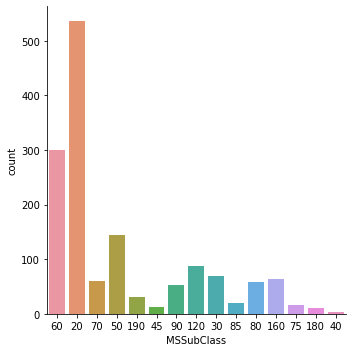

In [64]:
sbn.catplot(x='MSSubClass', kind='count', data=updated_df)

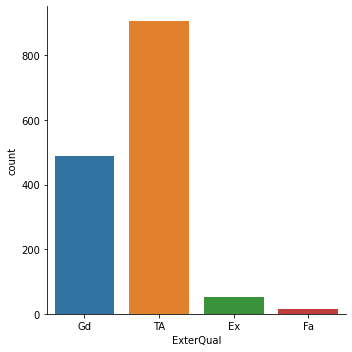

In [65]:
sbn.catplot(data=updated_df, x='ExterQual', kind='count')

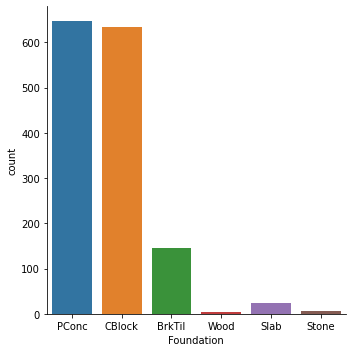

In [66]:
sbn.catplot(data=updated_df, x='Foundation', kind='count')

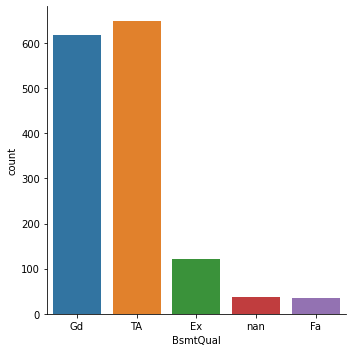

In [67]:
sbn.catplot(data=updated_df, x='BsmtQual', kind='count')

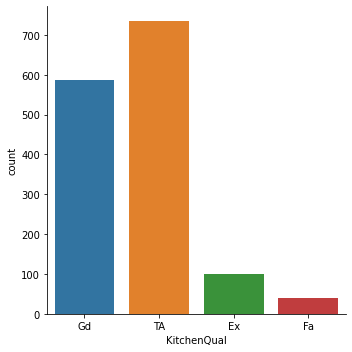

In [68]:
sbn.catplot(data=updated_df, x='KitchenQual', kind='count')

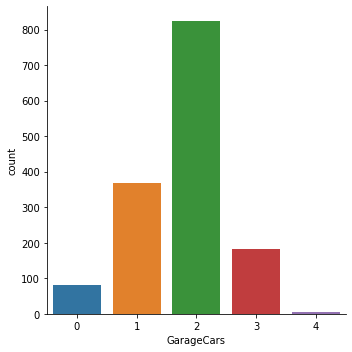

In [69]:
sbn.catplot(x='GarageCars', kind='count', data=updated_df)

### Using Neural network model (Keras)

In [70]:
def plot_graph(validation_data, training_data, graph_type):
    plt.clf()
    epochs = range(1, len(training_data) + 1)
    plt.plot(epochs, training_data, 'r', label='Training '+graph_type)
    plt.plot(epochs, validation_data, 'b', label='Validation '+graph_type)
    plt.title('Training and validation '+graph_type)
    plt.xlabel('Epochs')
    plt.ylabel(graph_type)
    plt.legend()
    plt.show()

In [71]:
from keras.utils import np_utils

In [72]:
X_train1 = X_train.copy()
Y_train1 = Y_train.copy()

In [73]:
# X_train1 = np_utils.to_categorical()

In [74]:
X_train1 = col_transform.fit_transform(X_train1)

In [75]:
len(X_train1[0])

223

In [76]:
from keras.layers import Dense, Dropout

In [77]:
X_test1 = X_test.copy()

In [78]:
X_test1 = X_test1.astype({i:'str' for i in ordinal_columns})
X_test1 = X_test1.astype({i:'str' for i in one_hot_columns})

In [79]:
X_test1 = col_transform.transform(X_test1)

In [80]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(223,)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(200, activation='relu'))
model.add(Dense(1))
model.compile(optimizer="nadam", loss="mean_squared_logarithmic_error", metrics=["mae"])
history = model.fit(X_train1, Y_train1, batch_size=16, validation_split=0.25, epochs=29)

2022-01-08 00:24:14.265089: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/29
69/69 [==============================] - 1s 6ms/step - loss: 33.4312 - mae: 177056.3594 - val_loss: 4.9472 - val_mae: 160773.3438
Epoch 2/29
69/69 [==============================] - 0s 4ms/step - loss: 1.8782 - mae: 126263.8438 - val_loss: 0.4099 - val_mae: 81469.3750
Epoch 3/29
69/69 [==============================] - 0s 4ms/step - loss: 0.2381 - mae: 64653.3711 - val_loss: 0.1435 - val_mae: 51664.8047
Epoch 4/29
69/69 [==============================] - 0s 4ms/step - loss: 0.1488 - mae: 53680.7500 - val_loss: 0.1180 - val_mae: 47581.2148
Epoch 5/29
69/69 [==============================] - 0s 4ms/step - loss: 0.1213 - mae: 48562.6914 - val_loss: 0.0947 - val_mae: 42792.7969
Epoch 6/29
69/69 [==============================] - 0s 4ms/step - loss: 0.0967 - mae: 42869.6289 - val_loss: 0.0727 - val_mae: 37327.0195
Epoch 7/29
69/69 [==============================] - 0s 4ms/step - loss: 0.0734 - mae: 37329.1289 - val_loss: 0.0560 - val_mae: 32625.1504
Epoch 8/29
69/69 [============

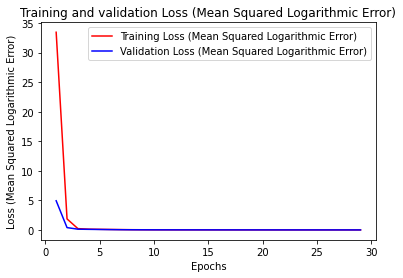

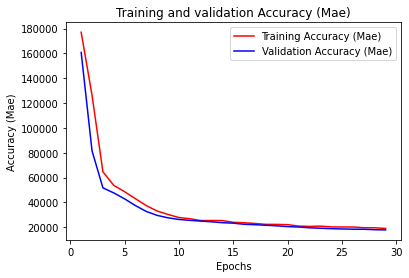

In [81]:
history = history.history
plot_graph(history['val_loss'], history['loss'], 'Loss (Mean Squared Logarithmic Error)')
plot_graph(history['val_mae'], history['mae'], 'Accuracy (Mae)')

In [82]:
model = Sequential()
model.add(Dense(800, activation='relu', input_shape=(223,)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_logarithmic_error", metrics=["mae"])
history1 = model.fit(X_train1, Y_train1, batch_size=10, validation_split=0.25, epochs=25)

Epoch 1/25
110/110 [==============================] - 1s 3ms/step - loss: 23.3181 - mae: 155565.4531 - val_loss: 0.3741 - val_mae: 77597.1641
Epoch 2/25
110/110 [==============================] - 0s 2ms/step - loss: 0.1813 - mae: 58449.7383 - val_loss: 0.1181 - val_mae: 47781.5664
Epoch 3/25
110/110 [==============================] - 0s 2ms/step - loss: 0.1007 - mae: 44230.4219 - val_loss: 0.0654 - val_mae: 35173.5156
Epoch 4/25
110/110 [==============================] - 0s 2ms/step - loss: 0.0575 - mae: 32587.7656 - val_loss: 0.0418 - val_mae: 28158.5938
Epoch 5/25
110/110 [==============================] - 0s 2ms/step - loss: 0.0417 - mae: 28103.0586 - val_loss: 0.0343 - val_mae: 25332.0938
Epoch 6/25
110/110 [==============================] - 0s 2ms/step - loss: 0.0346 - mae: 25598.0605 - val_loss: 0.0310 - val_mae: 24227.8574
Epoch 7/25
110/110 [==============================] - 0s 2ms/step - loss: 0.0317 - mae: 25083.1328 - val_loss: 0.0286 - val_mae: 22972.0391
Epoch 8/25
110/110

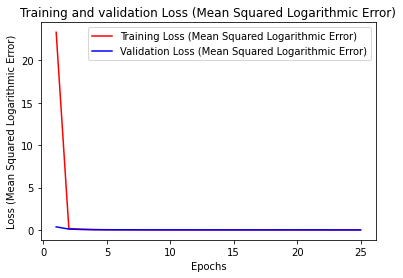

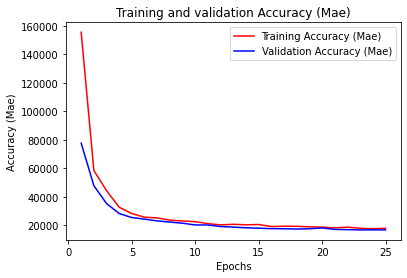

In [83]:
history1 = history1.history
plot_graph(history1['val_loss'], history1['loss'], 'Loss (Mean Squared Logarithmic Error)')
plot_graph(history1['val_mae'], history1['mae'], 'Accuracy (Mae)')

In [84]:
neural_prediction = model.predict(X_test1)

In [85]:
with (open('./neural-network-prediction.csv', 'w')) as file:
    writer = csv.writer(file)
    writer.writerow(['Id', 'SalePrice'])
    for index, val in enumerate(neural_prediction):
        writer.writerow([(1461+index), val[0]])

In [86]:
model = Sequential()
model.add(Dense(800, activation='relu', input_shape=(223,)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_logarithmic_error", metrics=["mae"])
history2 = model.fit(X_train1, Y_train1, batch_size=10, validation_split=0.25, epochs=20)

Epoch 1/20
110/110 [==============================] - 1s 5ms/step - loss: 24.2696 - mae: 157362.0312 - val_loss: 0.4340 - val_mae: 82944.6484
Epoch 2/20
110/110 [==============================] - 0s 2ms/step - loss: 0.1900 - mae: 58579.2930 - val_loss: 0.1219 - val_mae: 48373.3203
Epoch 3/20
110/110 [==============================] - 0s 3ms/step - loss: 0.1098 - mae: 45979.3086 - val_loss: 0.0746 - val_mae: 37751.8203
Epoch 4/20
110/110 [==============================] - 0s 2ms/step - loss: 0.0626 - mae: 35090.4219 - val_loss: 0.0461 - val_mae: 29784.6738
Epoch 5/20
110/110 [==============================] - 0s 2ms/step - loss: 0.0419 - mae: 28369.1035 - val_loss: 0.0354 - val_mae: 26495.1230
Epoch 6/20
110/110 [==============================] - 0s 2ms/step - loss: 0.0371 - mae: 26723.8184 - val_loss: 0.0313 - val_mae: 24343.3652
Epoch 7/20
110/110 [==============================] - 0s 2ms/step - loss: 0.0332 - mae: 25046.2090 - val_loss: 0.0288 - val_mae: 23107.8848
Epoch 8/20
110/110

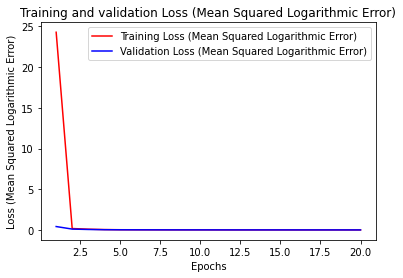

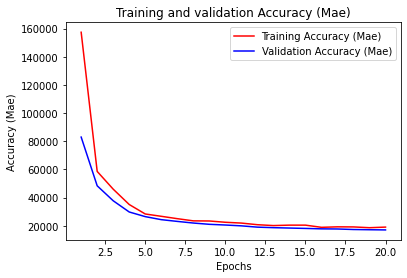

In [87]:
history2 = history2.history
plot_graph(history2['val_loss'], history2['loss'], 'Loss (Mean Squared Logarithmic Error)')
plot_graph(history2['val_mae'], history2['mae'], 'Accuracy (Mae)')

In [88]:
model.predict(X_train1)

array([[211660.61],
       [187098.92],
       [216051.17],
       ...,
       [244026.66],
       [153444.95],
       [158904.44]], dtype=float32)

In [89]:
Y_train1

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [90]:
model.evaluate(X_train1, Y_train1)

46/46 [==============================] - 0s 1ms/step - loss: 0.0145 - mae: 14858.5957


[0.014531395398080349, 14858.595703125]

In [91]:
# neural_prediction = model.predict(X_test1)

In [92]:
# with (open('./neural-network-prediction.csv', 'w')) as file:
#     writer = csv.writer(file)
#     writer.writerow(['Id', 'SalePrice'])
#     for index, val in enumerate(neural_prediction):
#         writer.writerow([(1461+index), val[0]])

### NOTE : The second neural network model performed better on the Kaggle with Root Mean Square Logarithmatic Error 0.12896